In [3]:
import os
import pandas as pd
import numpy as np
from typing import List
from rdkit import Chem
from rdkit.Chem import AllChem


import sys
sys.path.append("..")

from src.lazy_morgan import MorganBinaryClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt


DATAPATH = "../data"
DOCKING_FILE = "docking_scores_and_accessibilities_and_pocket_edist.tsv"

ModuleNotFoundError: No module named 'flaml'

In [3]:
df = pd.read_csv(os.path.join(DATAPATH,
                              "docking/docking_MurD/structures/SagaMurD_Frag373", 
                              DOCKING_FILE),sep='\t', header=0)


In [4]:
 #ECFP counts as described in REINVENT 2.0
def smiles_to_count_fingerprints(molecules: List, parameters: {}) -> []:
    radius = parameters.get('radius', 3)
    useCounts = parameters.get('use_counts', True)
    useFeatures = parameters.get('use_features', True)
    size = parameters.get('size', 2048)
    fps = [AllChem.GetMorganFingerprint(mol, radius, useCounts=useCounts, useFeatures=useFeatures) for mol in molecules]
    nfp = np.zeros((len(fps), size), np.int32)
    for i, fp in enumerate(fps):
        for idx, v in fp.GetNonzeroElements().items():
            nidx = idx % size
            nfp[i, nidx] += int(v)
        return nfp

def ecfp_counts(mols):
    fps = [AllChem.GetMorganFingerprint(mol, radius=3, useCounts=True, useFeatures=True) for mol in mols]
    nfp = np.zeros((len(fps), 2048), np.int32)
    for i, fp in enumerate(fps):
        for idx, v in fp.GetNonzeroElements().items():
            nidx = idx % 2048
            nfp[i, nidx] += int(v)
    return nfp

In [5]:
smiles = df["smiles"]
mols = [Chem.MolFromSmiles(smi) for smi in smiles]
ecfp = ecfp_counts(mols)

In [17]:
indices = np.arange(len(df))
X_train, X_test, y_train, y_test, i_train, i_test = train_test_split(
                                                                    ecfp, df["class"], 
                                                                    indices, 
                                                                    test_size=0.2)

#save split
with open("../models/docking_train.txt", "w") as f:
    for idx in i_train:
        f.write(str(idx)+"/n")
f.close()
with open("../models/docking_test.txt", "w") as f:
    for idx in i_test:
        f.write(str(idx)+"/n")
f.close()

In [19]:
from flaml import AutoML
mdl = AutoML()

TIME = 60
settings = {
    "time_budget":TIME * 60,
    "metric": 'roc_auc',
    "task": 'classification',
    "log_file_name": '../models/flaml_log.log',
    "verbose" : 3,
    "estimator_list": ["rf"]
    }

mdl.fit(X_train, y_train, **settings)


[flaml.automl: 06-20 23:56:37] {2385} INFO - task = classification
[flaml.automl: 06-20 23:56:37] {2387} INFO - Data split method: stratified
[flaml.automl: 06-20 23:56:37] {2391} INFO - Evaluation method: holdout
[flaml.automl: 06-20 23:56:38] {2460} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 06-20 23:56:38] {2600} INFO - List of ML learners in AutoML Run: ['rf']
[flaml.automl: 06-20 23:56:38] {2892} INFO - iteration 0, current learner rf
[flaml.automl: 06-20 23:56:39] {3023} INFO - Estimated sufficient time budget=91250s. Estimated necessary time budget=91s.
[flaml.automl: 06-20 23:56:39] {3075} INFO -  at 1.7s,	estimator rf's best error=0.4025,	best estimator rf's best error=0.4025
[flaml.automl: 06-20 23:56:39] {2892} INFO - iteration 1, current learner rf
[flaml.automl: 06-20 23:56:39] {3075} INFO -  at 2.1s,	estimator rf's best error=0.3304,	best estimator rf's best error=0.3304
[flaml.automl: 06-20 23:56:39] {2892} INFO - iteration 2, current learner rf
[flaml.auto

In [20]:
mdl.model.estimator

RandomForestClassifier(criterion='entropy', max_features=0.022097086912079608,
                       max_leaf_nodes=12603, n_estimators=244, n_jobs=-1)

In [21]:
import joblib
joblib.dump(mdl,"../models/docking_flaml.joblib")

['../models/docking_flaml.joblib']

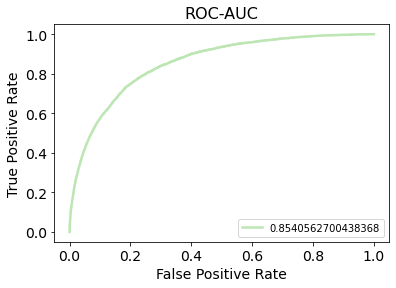

In [22]:
y_pred = mdl.predict_proba(X_test)


fpr_test, tpr_test, _ = metrics.roc_curve(y_test, y_pred[:,1])
auc_test = metrics.roc_auc_score(y_test, y_pred[:,1])

plt.plot(fpr_test, tpr_test, label = str(auc_test), lw=2.5, color = "#bee6b4")
plt.xlabel("False Positive Rate", fontsize =14)
plt.xticks(fontsize = 14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.yticks(fontsize = 14)
plt.title("ROC-AUC", fontsize=16)
plt.legend(loc = 'lower right')
plt.savefig(os.path.join("../figures", "roc_docking_flaml.png"))

RandomForestClassifier(criterion='entropy', max_features=0.022097086912079608,
                       max_leaf_nodes=12603, n_estimators=244, n_jobs=-1

In [4]:
#USE CONDA ENVIRONMENT WITH SKLEARN 0.21.3 and PYTHON 3.7 for REINVENT2.0 COMPATIBILITY
import os
import pandas as pd
import numpy as np
from typing import List
from rdkit import Chem
from rdkit.Chem import AllChem

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 244, max_features= 0.022097086912079608, 
max_leaf_nodes=12603, criterion='entropy')

/home/mduranfrigola/miniconda3/envs/reinvent/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/home/mduranfrigola/miniconda3/envs/reinvent/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release

In [6]:
#load X and Y
DATAPATH = "../data"
DOCKING_FILE = "docking_scores_and_accessibilities_and_pocket_edist.tsv"

df = pd.read_csv(os.path.join(DATAPATH,
                              "docking/docking_MurD/structures/SagaMurD_Frag373", 
                              DOCKING_FILE),sep='\t', header=0)

def ecfp_counts(mols):
    fps = [AllChem.GetMorganFingerprint(mol, radius=3, useCounts=True, useFeatures=True) for mol in mols]
    nfp = np.zeros((len(fps), 2048), np.int32)
    for i, fp in enumerate(fps):
        for idx, v in fp.GetNonzeroElements().items():
            nidx = idx % 2048
            nfp[i, nidx] += int(v)
    return nfp


smiles = df["smiles"]
mols = [Chem.MolFromSmiles(smi) for smi in smiles]
ecfp = ecfp_counts(mols)

In [48]:
#Use same train/test split
with open("../models/docking_train.txt", "r") as f:
    data = f.read()
    i_train = data.replace("/n", ",").split(",")
    i_train = i_train[:-1]
i_train = [int(i) for i in i_train]

with open("../models/docking_test.txt", "r") as f:
    data = f.read()
    i_test = data.replace("/n", ",").split(",")
    i_test = i_test[:-1]
i_test = [int(i) for i in i_test]

X_train = ecfp[i_train, :]
X_test = ecfp[i_test, :]

y_train = df["class"].loc[i_train]
y_test = df["class"].loc[i_test]

In [51]:
clf.fit(X_train, y_train)

/home/mduranfrigola/miniconda3/envs/reinvent/lib/python3.7/site-packages/sklearn/ensemble/forest.py:489: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_store_unique_indices = np.zeros(y.shape, dtype=np.int)
/home/mduranfrigola/miniconda3/envs/reinvent/lib/python3.7/site-packages/sklearn/utils/fixes.py:230: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if _joblib.__version__ >= LooseVersion('0.12'):
/home/mduranfrigola/miniconda3/envs/reinvent/lib/python3.7/site-packages/sklearn/tree/tree.py:163: D

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=0.022097086912079608,
                       max_leaf_nodes=12603, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=244, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [54]:
X_test = ecfp[i_test, :]

/home/mduranfrigola/miniconda3/envs/reinvent/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
/home/mduranfrigola/miniconda3/envs/reinvent/lib/python3.7/site-packages/sklearn/utils/fixes.py:230: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if _joblib.__version__ >= LooseVersion('0.12'):


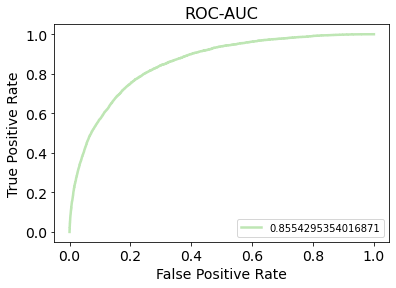

In [55]:
from sklearn import metrics
import matplotlib.pyplot as plt

y_pred = clf.predict_proba(X_test)


fpr_test, tpr_test, _ = metrics.roc_curve(y_test, y_pred[:,1])
auc_test = metrics.roc_auc_score(y_test, y_pred[:,1])

plt.plot(fpr_test, tpr_test, label = str(auc_test), lw=2.5, color = "#bee6b4")
plt.xlabel("False Positive Rate", fontsize =14)
plt.xticks(fontsize = 14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.yticks(fontsize = 14)
plt.title("ROC-AUC", fontsize=16)
plt.legend(loc = 'lower right')
plt.savefig(os.path.join("../figures", "roc_docking_sklearn.png"))

In [57]:
import joblib
joblib.dump(clf,"../models/docking_sklearn.joblib")

['../models/docking_sklearn.joblib']

In [1]:
import joblib
import pickle as pkl

clf = joblib.load("../models/docking_sklearn.joblib")
with open ("../models/docking_sklearn.pkl", "wb") as f:
    pkl.dump(clf, f)

/home/mduranfrigola/miniconda3/envs/reinvent/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/home/mduranfrigola/miniconda3/envs/reinvent/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release

# K-Nearest Neighbors

In [38]:
#datasets
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem

inh = pd.read_csv(os.path.join(DATAPATH, "murD_inhibition.csv"))
pocketvec = pd.read_csv("../pocketvec/PDB/pocketvec_molecules.tsv", sep='\t', header=None) #must clean cycles

def ecfp_counts(mols):
    fps = [AllChem.GetMorganFingerprint(mol, radius=3, useCounts=True, useFeatures=True) for mol in mols]
    nfp = np.zeros((len(fps), 2048), np.int32)
    for i, fp in enumerate(fps):
        for idx, v in fp.GetNonzeroElements().items():
            nidx = idx % 2048
            nfp[i, nidx] += int(v)
    return nfp

In [42]:
mols_pv = [Chem.MolFromInchi(i) for i in pocketvec[1]]
ecfp_pv = ecfp_counts(mols_pv)

mols_inh =[Chem.MolFromSmiles(s) for s in inh["SMILES"]]
ecfp_inh = ecfp_counts(mols_inh)

[10:32:24] WARNING:  (Metal compound) Problems/mismatches: Mobile-H( Hydrogens: Locations or number, Number; Charge(s): Do not match; Proton balance: Does not match); Disconnected:  Mobile-H( Charge(s): Do not match)

